# 16. So sánh hiệu năng các thuật toán Semi-Supervised

**Mục tiêu:**
Notebook này thực hiện một thử nghiệm toàn diện để so sánh hiệu năng và thời gian chạy của nhiều phương pháp học bán giám sát khác nhau, bao gồm:

1.  **Baseline**: `Self-Training` và `Co-Training` với cấu hình mặc định (sử dụng `HistGradientBoostingClassifier`).
2.  **Self-Training tùy chỉnh**: Áp dụng thuật toán `Self-Training` nhưng với các mô hình cơ sở khác là `RandomForestClassifier` và `KNeighborsClassifier`.
3.  **Thuật toán dựa trên đồ thị**: `LabelPropagation` và `LabelSpreading`.

**Kết quả mong đợi:**
*   **Biểu đồ 1**: So sánh chỉ số F1-Score của tất cả các phương pháp.
*   **Biểu đồ 2**: So sánh thời gian thực thi của chúng.

Qua đó, ta có thể đánh giá được sự đánh đổi giữa hiệu năng và chi phí tính toán của từng phương pháp.

## Bước 1. Cấu hình thử nghiệm

In [1]:
import time
from pathlib import Path
import json
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score
from sklearn.base import clone

# --- Cấu hình đường dẫn ---
PROJECT_ROOT = Path(".").resolve()
if not (PROJECT_ROOT / "data").exists() and (PROJECT_ROOT.parent / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent.resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
print(f"Project Root: {PROJECT_ROOT}")

# --- Import các hàm từ thư viện dự án ---
from src.semi_supervised_library import (
    SemiDataConfig, SelfTrainingConfig, CoTrainingConfig, run_self_training, run_co_training, AQI_CLASSES
)

# --- Cấu hình thử nghiệm ---
RANDOM_STATE = 42
SAMPLE_FRAC = 0.1

# Định nghĩa các mô hình cơ sở
rf_model = RandomForestClassifier(n_estimators=150, random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced')
knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

# Danh sách các thử nghiệm
EXPERIMENT_CONFIGS = {
    "Self-Training (Default)": {"type": "self_training_default"},
    "Co-Training (Default)": {"type": "co_training_default"},
    "Self-Training (Random Forest)": {"type": "self_training_custom", "model": rf_model},
    "Self-Training (KNN)": {"type": "self_training_custom", "model": knn_model},
    "LabelPropagation (KNN Kernel)": {"type": "label_propagation", "params": {'kernel': 'knn', 'n_neighbors': 7}},
    "LabelSpreading (KNN Kernel)": {"type": "label_spreading", "params": {'kernel': 'knn', 'n_neighbors': 7, 'alpha': 0.8}}
}

# --- Đường dẫn lưu trữ ---
CACHE_PATH = PROJECT_ROOT / "data" / "processed" / "16_full_comparison_cache.json"
IMAGES_DIR = PROJECT_ROOT / "images"
PROCESSED_DATA_DIR = PROJECT_ROOT / "data" / "processed"
IMAGES_DIR.mkdir(exist_ok=True)
PROCESSED_DATA_DIR.mkdir(exist_ok=True)

Project Root: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard


## Bước 2. Chuẩn bị dữ liệu

In [2]:
print("Đang tải và chuẩn bị dữ liệu...")
semi_dataset_path = PROJECT_ROOT / "data" / "processed" / "02_dataset_for_semi.parquet"
df_semi = pd.read_parquet(semi_dataset_path)

df_sample = df_semi.sample(frac=SAMPLE_FRAC, random_state=RANDOM_STATE)
print(f"Kích thước mẫu: {len(df_sample)} dòng ({SAMPLE_FRAC*100}%)")

# Mã hóa nhãn
label_encoder = LabelEncoder()
label_encoder.fit(AQI_CLASSES)
df_labeled = df_sample[df_sample['is_labeled']].copy()
df_labeled['aqi_class'] = label_encoder.transform(df_labeled['aqi_class'])

# Tách train/test từ dữ liệu đã gán nhãn
df_train_labeled = df_labeled[pd.to_datetime(df_labeled['datetime']) < '2017-01-01']
df_test = df_labeled[pd.to_datetime(df_labeled['datetime']) >= '2017-01-01']
df_unlabeled = df_sample[~df_sample['is_labeled']].copy()

# Lấy danh sách features
feature_list_path = PROJECT_ROOT / "data" / "processed" / "03_feature_list.csv"
df_features = pd.read_csv(feature_list_path)
numeric_features = [f for f in df_features["feature"] if f not in ['wd', 'station']]

# Chuẩn bị ma trận X, y
X_train_lab = df_train_labeled[numeric_features]
y_train_lab = df_train_labeled['aqi_class']
X_test = df_test[numeric_features]
y_test = df_test['aqi_class']
X_unlabeled = df_unlabeled[numeric_features]

# Xử lý missing và chuẩn hóa
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

X_train_lab_scaled = scaler.fit_transform(imputer.fit_transform(X_train_lab))
X_test_scaled = scaler.transform(imputer.transform(X_test))
X_unlabeled_scaled = scaler.transform(imputer.transform(X_unlabeled))

print("✅ Dữ liệu đã sẵn sàng!")

Đang tải và chuẩn bị dữ liệu...
Kích thước mẫu: 42077 dòng (10.0%)
✅ Dữ liệu đã sẵn sàng!


## Bước 3. Chạy các thử nghiệm

In [3]:
final_results = []
cached_results = {}

if CACHE_PATH.exists():
    with open(CACHE_PATH, 'r') as f:
        cached_results = json.load(f)
    print(f"Đã tải {len(cached_results)} kết quả từ cache.")

# --- Đường dẫn tới file metrics của các notebook trước ---
SELF_TRAINING_METRICS_PATH = PROJECT_ROOT / "data" / "processed" / "04_metrics_self_training.json"
CO_TRAINING_METRICS_PATH = PROJECT_ROOT / "data" / "processed" / "05_metrics_co_training.json"


for name, config in EXPERIMENT_CONFIGS.items():
    print(f"\n--- Đang xử lý: {name} ---")

    if name in cached_results:
        print("✅ Kết quả đã có trong cache. Đang tải...")
        final_results.append(cached_results[name])
        continue

    start_time = time.time()
    f1 = 0
    result = {}

    # --- Logic mới: Đọc kết quả cho các thuật toán default ---
    if config['type'] == 'self_training_default':
        print("Đọc kết quả từ file 04_metrics_self_training.json...")
        if SELF_TRAINING_METRICS_PATH.exists():
            with open(SELF_TRAINING_METRICS_PATH, 'r') as f:
                data = json.load(f)
            f1 = data['test_metrics']['f1_macro']
            # Gán thời gian chạy là NaN vì không thực thi lại
            result = {'model': name, 'f1_macro': f1, 'execution_time': np.nan}
        else:
            print(f"   LỖI: Không tìm thấy file {SELF_TRAINING_METRICS_PATH}")
            result = {'model': name, 'f1_macro': 0, 'execution_time': np.nan}

    elif config['type'] == 'co_training_default':
        print("Đọc kết quả từ file 05_metrics_co_training.json...")
        if CO_TRAINING_METRICS_PATH.exists():
            with open(CO_TRAINING_METRICS_PATH, 'r') as f:
                data = json.load(f)
            f1 = data['test_metrics']['f1_macro']
            result = {'model': name, 'f1_macro': f1, 'execution_time': np.nan}
        else:
            print(f"   LỖI: Không tìm thấy file {CO_TRAINING_METRICS_PATH}")
            result = {'model': name, 'f1_macro': 0, 'execution_time': np.nan}

    # --- Chạy các thử nghiệm mới như cũ ---
    else:
        if config['type'] == 'self_training_custom':
            model = clone(config['model'])
            # Tự triển khai vòng lặp self-training cho model tùy chỉnh
            X_train_curr, y_train_curr = X_train_lab_scaled.copy(), y_train_lab.copy().values
            X_unlabeled_pool = X_unlabeled_scaled.copy()
            
            for _ in range(10): # 10 iterations
                if len(X_unlabeled_pool) == 0: break
                model.fit(X_train_curr, y_train_curr)
                proba = model.predict_proba(X_unlabeled_pool)
                y_pred_unlabeled = model.predict(X_unlabeled_pool)
                max_proba = proba.max(axis=1)
                confident_mask = max_proba >= 0.9
                if not np.any(confident_mask): break
                
                X_new = X_unlabeled_pool[confident_mask]
                y_new = y_pred_unlabeled[confident_mask]
                
                X_train_curr = np.vstack([X_train_curr, X_new])
                y_train_curr = np.concatenate([y_train_curr, y_new])
                X_unlabeled_pool = np.delete(X_unlabeled_pool, np.where(confident_mask), axis=0)
            
            model.fit(X_train_curr, y_train_curr) # Huấn luyện lần cuối
            y_pred_test = model.predict(X_test_scaled)
            f1 = f1_score(y_test, y_pred_test, average='macro', zero_division=0)

        elif config['type'] in ['label_propagation', 'label_spreading']:
            X_combined = np.vstack([X_train_lab_scaled, X_unlabeled_scaled])
            y_unlabeled_markers = np.full(len(X_unlabeled_scaled), -1)
            y_combined = np.concatenate([y_train_lab.values, y_unlabeled_markers])
            
            if config['type'] == 'label_propagation':
                model = LabelPropagation(**config['params'])
            else:
                model = LabelSpreading(**config['params'])
                
            model.fit(X_combined, y_combined)
            y_pred_test = model.predict(X_test_scaled)
            f1 = f1_score(y_test, y_pred_test, average='macro', zero_division=0)

        end_time = time.time()
        exec_time = end_time - start_time
        result = {'model': name, 'f1_macro': f1, 'execution_time': exec_time}
        print(f"   -> Hoàn thành trong {exec_time:.2f}s, F1-Macro: {f1:.4f}")

    final_results.append(result)
    cached_results[name] = result

# Lưu lại cache
with open(CACHE_PATH, 'w') as f:
    json.dump(cached_results, f, indent=2)
print("\n✅ Đã cập nhật cache.")

df_results = pd.DataFrame(final_results)



--- Đang xử lý: Self-Training (Default) ---
Đọc kết quả từ file 04_metrics_self_training.json...

--- Đang xử lý: Co-Training (Default) ---
Đọc kết quả từ file 05_metrics_co_training.json...

--- Đang xử lý: Self-Training (Random Forest) ---
   -> Hoàn thành trong 10.79s, F1-Macro: 0.4153

--- Đang xử lý: Self-Training (KNN) ---
   -> Hoàn thành trong 21.70s, F1-Macro: 0.3142

--- Đang xử lý: LabelPropagation (KNN Kernel) ---


c:\Users\ThanhTung\.conda\envs\KhaiPhaDuLieu_Pro01\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:324: ConvergenceWarning: max_iter=1000 was reached without convergence.
  warnings.warn(


   -> Hoàn thành trong 13.57s, F1-Macro: 0.3126

--- Đang xử lý: LabelSpreading (KNN Kernel) ---


c:\Users\ThanhTung\.conda\envs\KhaiPhaDuLieu_Pro01\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:324: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(


   -> Hoàn thành trong 4.43s, F1-Macro: 0.3497

✅ Đã cập nhật cache.


## Bước 4. Trực quan hóa và Phân tích

Biểu đồ so sánh đã lưu tại: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\images\16_full_comparison.png
Dữ liệu so sánh đã lưu tại: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\data\processed\16_full_comparison.csv


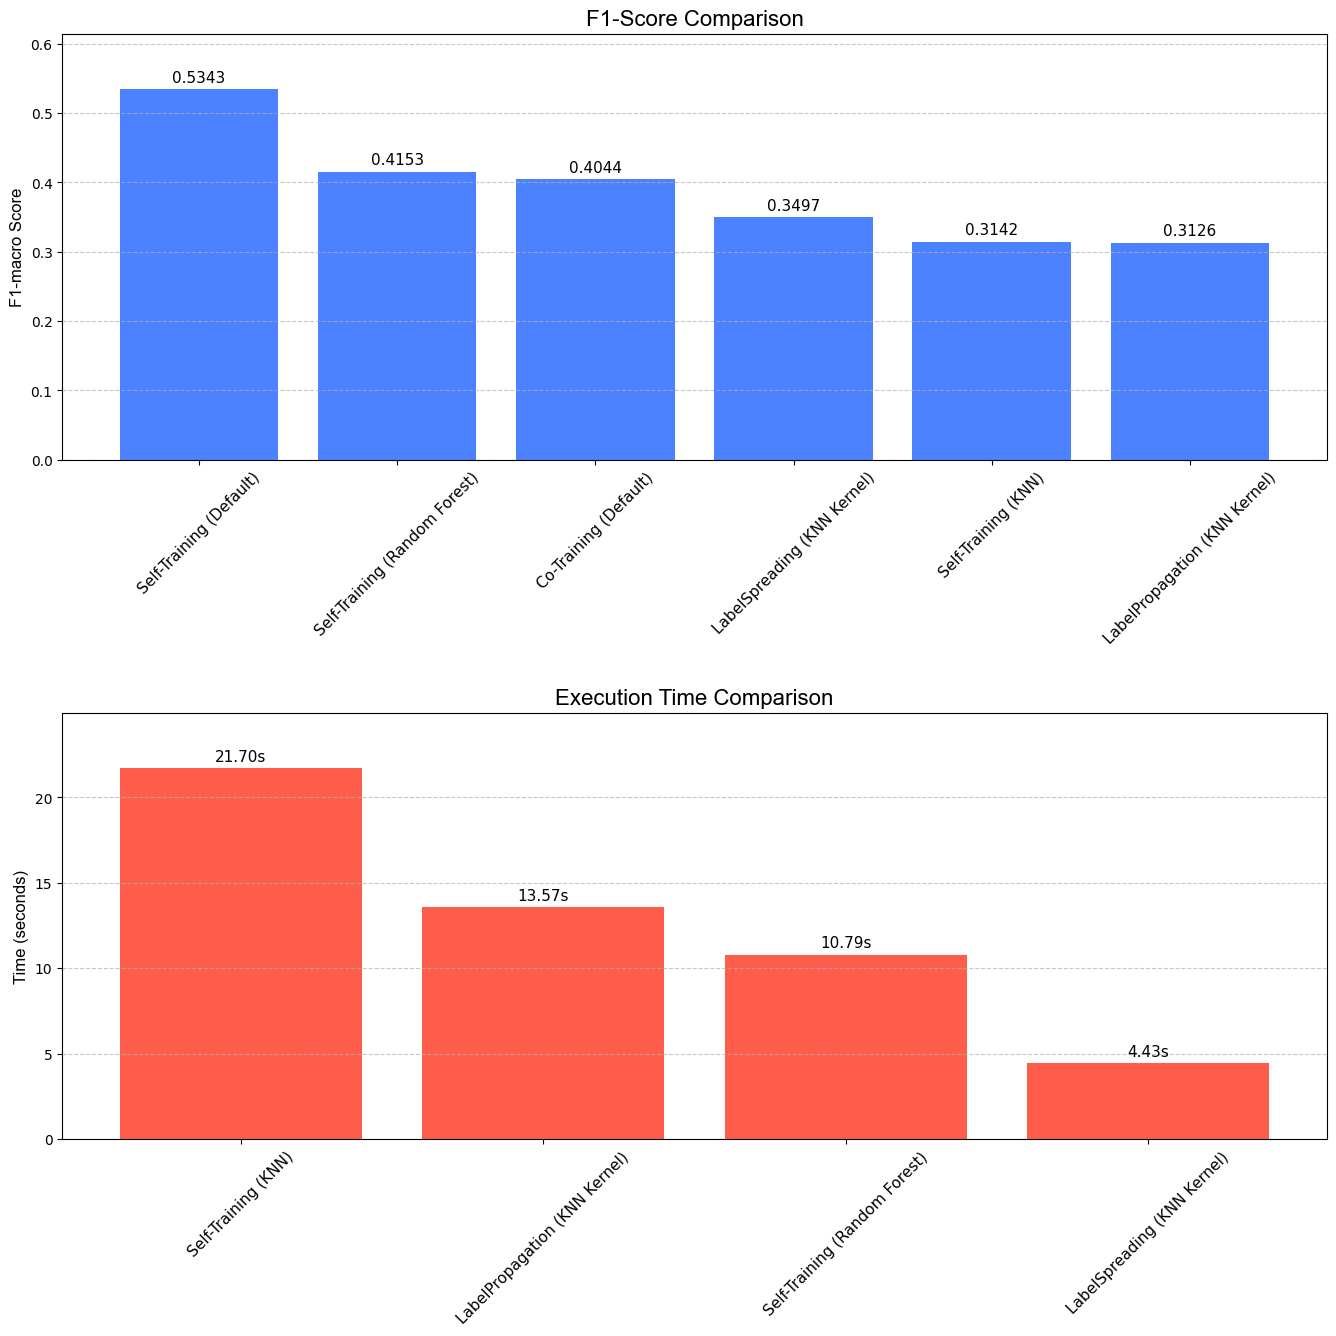

In [4]:
if not df_results.empty:
    fig, axes = plt.subplots(2, 1, figsize=(14, 14))
    
    # --- Biểu đồ 1: So sánh F1-Score ---
    df_f1 = df_results.sort_values('f1_macro', ascending=False)
    bars_f1 = axes[0].bar(df_f1['model'], df_f1['f1_macro'], color='#1F62FF', alpha=0.8)
    axes[0].set_title('F1-Score Comparison', fontsize=16, fontfamily='Arial')
    axes[0].set_ylabel('F1-macro Score', fontsize=12, fontfamily='Arial')
    axes[0].tick_params(axis='x', rotation=45, labelsize=11)
    axes[0].bar_label(bars_f1, fmt='%.4f', fontsize=11, padding=3)
    axes[0].set_ylim(0, df_f1['f1_macro'].max() * 1.15)

    # --- Biểu đồ 2: So sánh thời gian chạy ---
    df_time = df_results.sort_values('execution_time', ascending=False)
    bars_time = axes[1].bar(df_time['model'], df_time['execution_time'], color='#FF351F', alpha=0.8)
    axes[1].set_title('Execution Time Comparison', fontsize=16, fontfamily='Arial')
    axes[1].set_ylabel('Time (seconds)', fontsize=12, fontfamily='Arial')
    axes[1].tick_params(axis='x', rotation=45, labelsize=11)
    axes[1].bar_label(bars_time, fmt='%.2fs', fontsize=11, padding=3)
    axes[1].set_ylim(0, df_time['execution_time'].max() * 1.15)

    # --- Định dạng chung ---
    for ax in axes:
        ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout(pad=3.0)

    # --- Lưu kết quả ---
    fig_path = IMAGES_DIR / "16_full_comparison.png"
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"Biểu đồ so sánh đã lưu tại: {fig_path}")

    csv_path = PROCESSED_DATA_DIR / "16_full_comparison.csv"
    df_results.to_csv(csv_path, index=False)
    print(f"Dữ liệu so sánh đã lưu tại: {csv_path}")

    plt.show()
else:
    print("Không có kết quả để hiển thị.")